In [1]:
import os
import sys
import pandas as pd
import numpy as np
from collections import defaultdict
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from fastdtw import fastdtw

from sklearn.preprocessing import StandardScaler

# Import library with current code functions
sys.path.append(os.path.join("..", "lib"))
import general_functions as gf, files_paths as fp

In [2]:
# Function to calculate Euclidean distance between two time series
def calculate_euclidean_distance(seed_i, seed_j):
    distance = np.sqrt(np.sum((np.array(seed_i) - np.array(seed_j)) ** 2))
    return distance

In [3]:
def calculate_dtw_distance(series1, series2):
    distance, path = fastdtw(series1, series2)
    return distance

In [4]:
# Function to normalize a series between 0 and 1
def normalize_min_max(series):
    min_val = np.min(series)
    max_val = np.max(series)
    return (series - min_val) / (max_val - min_val) if max_val != min_val else series

In [5]:
def compute_euclidean_distances_matrix(all_measures_vector):
    num_measures = len(all_measures_vector)  # Number of measures
    num_seeds = len(all_measures_vector['m1'])  # Number of seeds for the first measure
    print("Number of measures:", num_measures)
    
    final_distances_matrix = {
        'm1': [[0] * num_seeds for _ in range(num_seeds)],
        'm3': [[0] * num_seeds for _ in range(num_seeds)],
        'm12': [[0] * num_seeds for _ in range(num_seeds)],
        'e1': [[0] * num_seeds for _ in range(num_seeds)],
        'e2': [[0] * num_seeds for _ in range(num_seeds)]
    }
    
    # Set the required length for the series
    required_length = 30

    # Iterate over each measure and calculate the Euclidean distances and correlations for series of length 30
    for current_measure in all_measures_vector:
        seeds_for_current_measure = all_measures_vector[current_measure]

        for i, seed_i in enumerate(seeds_for_current_measure):
            # Pad the series if its length is less than the required length
            if len(seed_i) < required_length:
                seed_i = np.pad(seed_i, (0, required_length - len(seed_i)), 'constant', constant_values=0)
            
            # Normalize seed_i between 0 and 1
            seed_i = normalize_min_max(seed_i)
            
            # Only consider series that are now of length 30
            if len(seed_i) == required_length:
                for j, seed_j in enumerate(seeds_for_current_measure):
                    # Pad the series if its length is less than the required length
                    if len(seed_j) < required_length:
                        seed_j = np.pad(seed_j, (0, required_length - len(seed_j)), 'constant', constant_values=0)
                    
                    # Normalize seed_j between 0 and 1
                    seed_j = normalize_min_max(seed_j)
                    
                    # Only compare with series of length 30
                    if len(seed_j) == required_length:
                        # Calculate Euclidean distance and correlation
                        seed_distance = calculate_euclidean_distance(seed_i, seed_j)

                        # Store the distance and correlation in the final matrices
                        final_distances_matrix[current_measure][i][j] = seed_distance

    return final_distances_matrix

In [6]:
def compute_dtw_distances_matrix(all_measures_vector):
    num_measures = len(all_measures_vector)  # Número de medidas
    num_seeds = len(all_measures_vector['m1'])  # Número de sementes para a primeira medida
    print("Número de medidas:", num_measures)

    # Inicializar as matrizes de distâncias DTW
    final_distances_matrix = {
        'm1': [[0] * num_seeds for _ in range(num_seeds)],
        'm3': [[0] * num_seeds for _ in range(num_seeds)],
        'm12': [[0] * num_seeds for _ in range(num_seeds)],
        'e1': [[0] * num_seeds for _ in range(num_seeds)],
        'e2': [[0] * num_seeds for _ in range(num_seeds)]
    }
    
    # Iterar sobre cada medida e calcular as distâncias DTW
    for current_measure in all_measures_vector:
        seeds_for_current_measure = all_measures_vector[current_measure]

        for i, seed_i in enumerate(seeds_for_current_measure):
            # Normalizar seed_i entre 0 e 1 (opcional)
            seed_i = normalize_min_max(seed_i)
            
            for j, seed_j in enumerate(seeds_for_current_measure):
                # Normalizar seed_j entre 0 e 1 (opcional)
                seed_j = normalize_min_max(seed_j)
                
                # Calcular a distância DTW entre seed_i e seed_j
                seed_distance = calculate_dtw_distance(seed_i, seed_j)

                # Armazenar a distância na matriz final
                final_distances_matrix[current_measure][i][j] = seed_distance

    return final_distances_matrix


In [7]:
def plot_distance_all_measures(final_distances_matrix):
    measures = list(final_distances_matrix.keys())
    measures = ['m3', 'm12']

    # Encontrar o valor mínimo e máximo global para definir a mesma escala de cores
    all_distances = np.concatenate([np.ravel(final_distances_matrix[measure]) for measure in measures])
    vmin = np.min(all_distances)
    vmax = np.max(all_distances)

    # Criar o grid para plotar
    n_measures = len(measures)
    nrows = (n_measures // 2) + (n_measures % 2)  # Número de linhas necessário
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, nrows * 5))
    axes = axes.flatten()  # Facilita a indexação

    # Plotar cada matriz de distâncias Euclidianas
    for ax, measure in zip(axes, measures):
        # Usar os mesmos valores de vmin e vmax para garantir que todas as escalas de cor sejam iguais
        cax = ax.matshow(final_distances_matrix[measure], cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f'Distance - {measure}')
        ax.set_xlabel('Seeds')
        ax.set_ylabel('Seeds')
        plt.colorbar(cax, ax=ax)

    # Ocultar eixos não utilizados se houver um número ímpar de medidas
    for i in range(n_measures, len(axes)):
        fig.delaxes(axes[i])

    # Ajustar layout
    plt.tight_layout()
    plt.show()


In [8]:
def plot_simple_graph(final_distances_vector):
    x_indices = np.arange(len(final_distances_vector))
    
    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, final_distances_vector, marker='o', linestyle='-', color='b', markersize=5)
    
    # Definir título e rótulos
    plt.xlabel("Seeds", fontsize=14)
    plt.ylabel("Euclidean Distance", fontsize=14)
    
    # Adicionar grade
    plt.grid()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

In [9]:
def plot_simple_series(final_distances_matrix):
    # Itera sobre cada medida na matriz de distâncias
    measures = final_distances_matrix.keys()
    
    # Configura o gráfico
    plt.figure(figsize=(12, 8))
    
    for measure in measures:
        # Extrai as distâncias para a primeira série
        distances = final_distances_matrix[measure][0]  # Pega o primeiro item de cada medida
        plt.plot(distances, label=measure)  # Plota as distâncias
    
    # Adiciona título e rótulos
    plt.xlabel("Seeds")
    plt.ylabel("Euclidean Distance")
    plt.legend()
    plt.grid()
    
    # Exibe o gráfico
    plt.show()


In [10]:
# Função para ajustar o comprimento da série temporal
def pad_or_truncate(series, length):
    if len(series) < length:
        # Preencher com zeros se for menor
        series = np.pad(series, (0, length - len(series)), 'constant', constant_values=0)
    elif len(series) > length:
        # Cortar se for maior
        series = series[:length]
    return series


In [11]:
FILE_LIST_VD_LABELED_FILE_SEED = gf.find_files_in_all_subdirectories([fp.DATASET_SEED], "*LABELED*")
FILE_LIST_VD_INFO = gf.find_files_in_all_subdirectories([fp.DATASET_SEED], "*INFO*")

In [12]:
FILE_LIST_VD_LABELED_FILE_SEED

['..\\Dataset\\REF-Gold-Label\\VD_R_0000000001\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000002\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000003\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000004\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000005\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000006\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000007\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000008\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000009\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000010\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000011\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000012\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000013\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000014\\VD_LABELED_L0.CSV',
 '..\\Dataset\\REF-Gold-Label\\VD_R_0000000015\\

In [13]:
happy_num = 0

for vd_info_file_path in FILE_LIST_VD_INFO:
    df = pd.read_csv(vd_info_file_path)
    if 'happy' in df['link_video'].values[0]:
        print("happy_num:", happy_num)
        happy_num += 1
        print("Number of frames", df['total_frames'].values)
        print("vd_info_file_path", vd_info_file_path)

happy_num: 0
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000001\VD_INFO.CSV
happy_num: 1
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000002\VD_INFO.CSV
happy_num: 2
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000003\VD_INFO.CSV
happy_num: 3
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000007\VD_INFO.CSV
happy_num: 4
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000008\VD_INFO.CSV
happy_num: 5
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000009\VD_INFO.CSV
happy_num: 6
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000013\VD_INFO.CSV
happy_num: 7
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000014\VD_INFO.CSV
happy_num: 8
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000015\VD_INFO.CSV
happy_num: 9
Number of frames [30]
vd

In [14]:
#NOVO

others_num = 0

for vd_info_file_path in FILE_LIST_VD_INFO:
    df = pd.read_csv(vd_info_file_path)
    if 'others' in df['link_video'].values[0]:
        print("others_num:", others_num)
        others_num += 1
        print("Number of frames", df['total_frames'].values)
        print("vd_info_file_path", vd_info_file_path)

others_num: 0
Number of frames [29]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000139\VD_INFO.CSV
others_num: 1
Number of frames [29]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000140\VD_INFO.CSV
others_num: 2
Number of frames [24]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000141\VD_INFO.CSV
others_num: 3
Number of frames [29]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000142\VD_INFO.CSV
others_num: 4
Number of frames [29]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000143\VD_INFO.CSV
others_num: 5
Number of frames [29]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000144\VD_INFO.CSV
others_num: 6
Number of frames [29]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000145\VD_INFO.CSV
others_num: 7
Number of frames [30]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000146\VD_INFO.CSV
others_num: 8
Number of frames [29]
vd_info_file_path ..\Dataset\REF-Gold-Label\VD_R_0000000147\VD_INFO.CSV
others_num: 9
Number of fram

Carregar Valores de Happy,Neutral e Other

In [15]:
measures_to_analyse = ['m1', 'm3', 'm12', 'e1', 'e2']
all__happy_measures_vector = {'m1': [], 'm3': [], 'm12': [], 'e1': [], 'e2': []}
all__neutral_measures_vector = {'m1': [], 'm3': [], 'm12': [], 'e1': [], 'e2': []}

# Inicializar as medidas para 'others'
others_measures_vector = {'m3': [], 'm12': []}

for measure in measures_to_analyse:
    for labeled_seed_file in FILE_LIST_VD_LABELED_FILE_SEED:
        current_labeled_seed_df = pd.read_csv(labeled_seed_file)
        labeled_seed_measure_analyzing = current_labeled_seed_df[measure]
        if 'happy' in current_labeled_seed_df['label_measures'][0]:
            all__happy_measures_vector[measure].append(labeled_seed_measure_analyzing)
        elif 'neutral' in current_labeled_seed_df['label_measures'][0]:
            all__neutral_measures_vector[measure].append(labeled_seed_measure_analyzing)

# Adicionar lógica para carregar a seed 'others'
for labeled_seed_file in FILE_LIST_VD_LABELED_FILE_SEED:
    current_labeled_seed_df = pd.read_csv(labeled_seed_file)
    
    # Verificar se o rótulo é 'others'
    label_measures = current_labeled_seed_df['label_measures'].iloc[0]  # Pegamos o primeiro rótulo do arquivo
    if 'others' in label_measures:  # Confirmamos que é do tipo 'others'
        for measure in ['m3', 'm12']:  # Apenas m3 e m12 são relevantes para 'others'
            others_measures_vector[measure].append(labeled_seed_measure_analyzing)

In [61]:
#NOVO

#Trecho para comparar distancias entre happy,neutral e others

# Definir o comprimento necessário para as séries
required_length = 30


# Inicializar os resultados das distâncias
distances_happy = {'m3': [], 'm12': []}
distances_neutral = {'m3': [], 'm12': []}


for measure in ['m3', 'm12']:
    # Para cada seed de 'happy', calcule a distância
    for happy_seed in all__happy_measures_vector[measure]:
        # Ajustar os comprimentos
        happy_seed = pad_or_truncate(happy_seed, required_length)
        others_seed = pad_or_truncate(others_measures_vector[measure][0], required_length)
        
        # Calcular a distância
        distance = calculate_euclidean_distance(others_seed, happy_seed)
        distances_happy[measure].append(distance)

    # Para cada seed de 'neutral', calcule a distância
    for neutral_seed in all__neutral_measures_vector[measure]:
        # Ajustar os comprimentos
        neutral_seed = pad_or_truncate(neutral_seed, required_length)
        others_seed = pad_or_truncate(others_measures_vector[measure][0], required_length)
        
        # Calcular a distância
        distance = calculate_euclidean_distance(others_seed, neutral_seed)
        distances_neutral[measure].append(distance)




In [ ]:
#NOVO

# Gerar os gráficos comparativos para 'm3' e 'm12' em BARRAS
def plot_comparison_graph(distances, title):
    plt.figure(figsize=(16, 6))
    plt.bar(range(1, len(distances) + 1), distances, color='skyblue', edgecolor='black')
    plt.xlabel('Amostras')
    plt.ylabel('Distância')
    plt.title(title)
    plt.xticks(ticks=range(1, len(distances) + 1), labels=range(1, len(distances) + 1), rotation=0)  # Mostra o índice das 54 amostras no eixo X
    plt.tight_layout()
    plt.show()

# Plotar os gráficos para a seed 'others' comparando com happy e neutral
for measure in ['m3', 'm12']:
    # Distâncias com as amostras de 'happy'
    plot_comparison_graph(distances_happy[measure],
                          title=f"Distâncias da Seed 'others' com Amostras 'Happy' - Medida {measure}")
    
    # Distâncias com as amostras de 'neutral'
    plot_comparison_graph(distances_neutral[measure],
                          title=f"Distâncias da Seed 'others' com Amostras 'Neutral' - Medida {measure}")


NameError: name 'distances_happy' is not defined

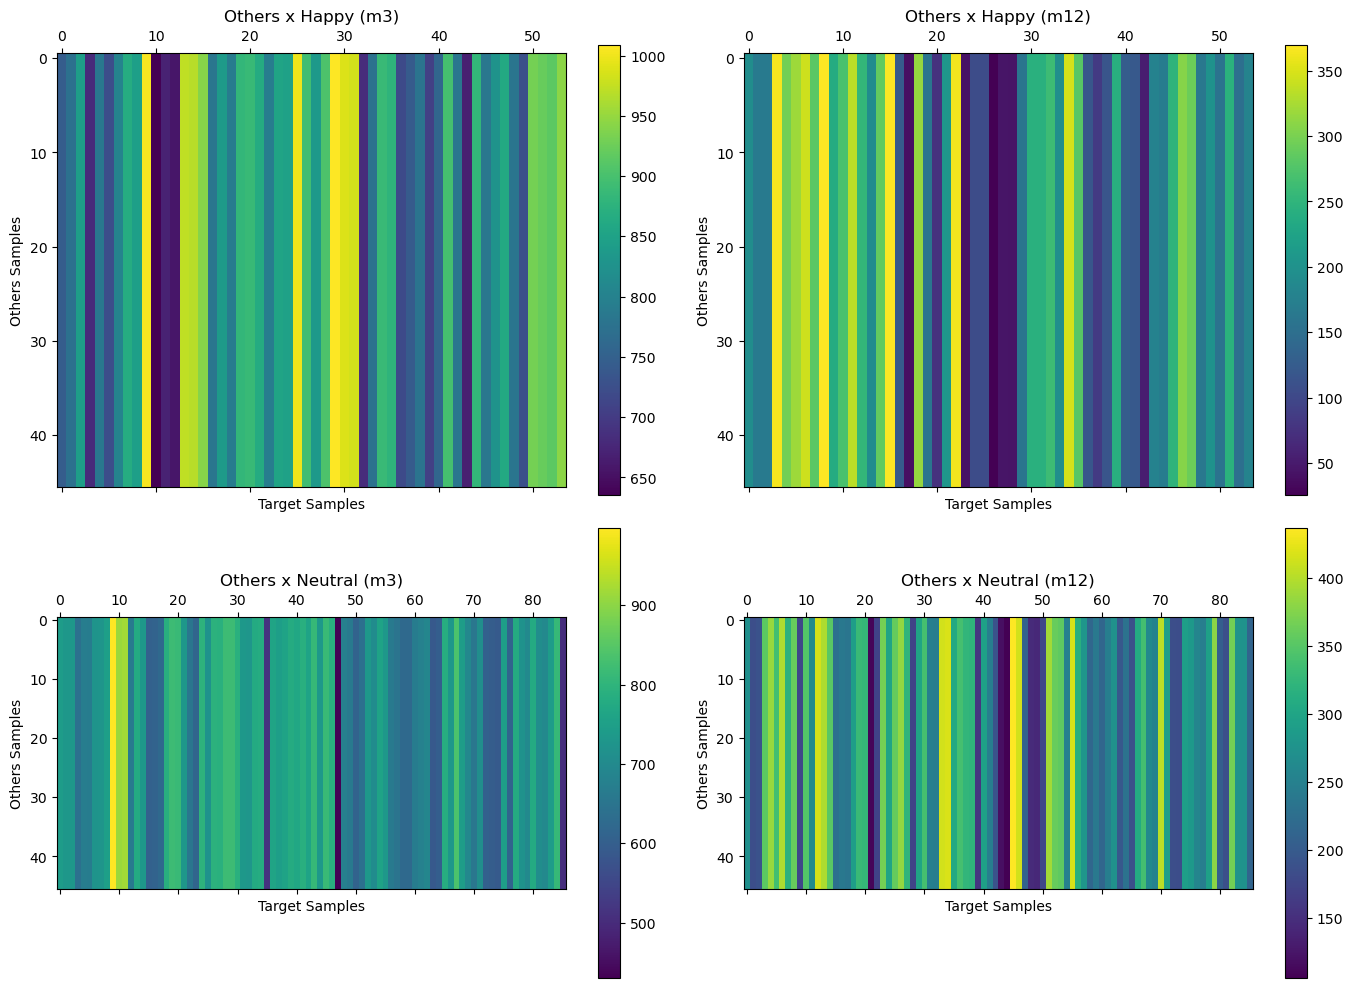

In [35]:
#NOVO

#Matriz de similaridade Others X Happy e Others X Neutral para m3 e m12 e Gerar os graficos

def compute_distances_specific(others_vector, target_vector, measure):
    """
    Calcula as distâncias entre as séries de 'others' e 'target' (happy ou neutral).
    """
    required_length = 30

    # Padronizar todas as séries
    others_standardized = [pad_or_truncate(series, required_length) for series in others_vector]
    target_standardized = [pad_or_truncate(series, required_length) for series in target_vector]

    # Inicializar a matriz de distâncias
    num_others = len(others_standardized)
    num_target = len(target_standardized)
    distance_matrix = np.zeros((num_others, num_target))

    # Calcular as distâncias
    for i, other in enumerate(others_standardized):
        for j, target in enumerate(target_standardized):
            distance_matrix[i, j] = calculate_euclidean_distance(other, target)

    return distance_matrix

def plot_distance_matrices(distances, measures):
    """
    Plota as matrizes de distância para os diferentes grupos e medidas.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, (distance_matrix, measure) in enumerate(zip(distances, measures)):
        cax = axes[i].matshow(distance_matrix, cmap='viridis')
        axes[i].set_title(f'{measure}')
        axes[i].set_xlabel('Target Samples')
        axes[i].set_ylabel('Others Samples')
        plt.colorbar(cax, ax=axes[i])

    plt.tight_layout()
    plt.show()

# Cálculo das matrizes de distância
distances_m3_happy = compute_distances_specific(others_measures_vector['m3'], all__happy_measures_vector['m3'], 'm3')
distances_m12_happy = compute_distances_specific(others_measures_vector['m12'], all__happy_measures_vector['m12'], 'm12')
distances_m3_neutral = compute_distances_specific(others_measures_vector['m3'], all__neutral_measures_vector['m3'], 'm3')
distances_m12_neutral = compute_distances_specific(others_measures_vector['m12'], all__neutral_measures_vector['m12'], 'm12')

# Plotar os gráficos
plot_distance_matrices(
    distances=[
        distances_m3_happy, distances_m12_happy,
        distances_m3_neutral, distances_m12_neutral
    ],
    measures=['Others x Happy (m3)', 'Others x Happy (m12)', 'Others x Neutral (m3)', 'Others x Neutral (m12)']
)


In [35]:
final_euclidean_distances_matrix = compute_euclidean_distances_matrix(all__happy_measures_vector)

Number of measures: 5


In [21]:
final_dtw_distances_matrix = compute_dtw_distances_matrix(all__happy_measures_vector)

Número de medidas: 5


In [20]:
#plot_distance_all_measures(final_dtw_distances_matrix)

NameError: name 'final_dtw_distances_matrix' is not defined

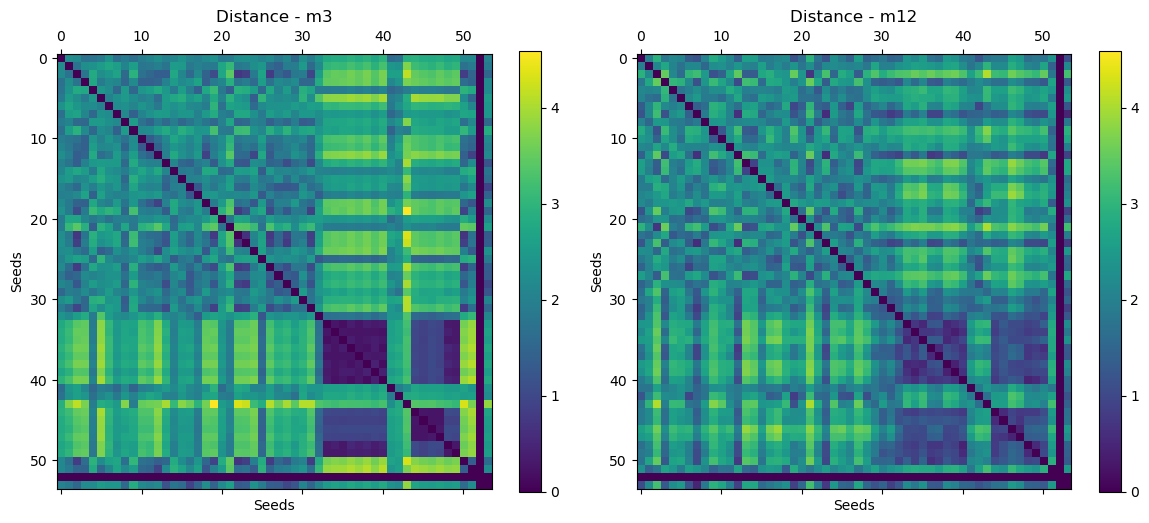

In [17]:
plot_distance_all_measures(final_euclidean_distances_matrix)

In [18]:
plot_simple_series(final_dtw_distances_matrix)

NameError: name 'final_dtw_distances_matrix' is not defined

In [19]:
plot_simple_graph(final_dtw_distances_matrix['m1'][0])

NameError: name 'final_dtw_distances_matrix' is not defined